# Predictive Maintenance

## Project Scope
The team will review and analyze sensor data of manufacturing dryers, identify factors that contribute to unscheduled maintenance, and develop a predictive maintenance model to reduce dryer failure.

## Set Up Environment

In [1]:
# set default plot size
options(repr.plot.width=7, repr.plot.height=5)
options(warn = FALSE)

In [3]:
# load packages
library(RMySQL)
library(lubridate)
library(tidyverse)

## Load and check data

In [ ]:
# create an open connection to the database
cn <- dbConnect(drv = RMySQL::MySQL(),
                host = "host",
                port = 3306,
                user = "user",
                password = "password",
                dbname = "db")

# query the database and store the results into a DataFrame
df <- dbGetQuery(cn, "SELECT * FROM machine3 WHERE quality = 192")
dbDisconnect(cn)

In [ ]:
# save df to local machine
saveRDS(df, "machine3.Rda")
df <- readRDS("machine3.Rda")

In [5]:
# inspect the structure of the dataframe
#str(df)

In [11]:
# show summary statistics for all variables to decide which variables are binary
#summary(df)

In [12]:
# convert Datetime variable to DateTime value
df$Datetime <- ymd_hms(df$Datetime)

# convert 1/0 variables to factors
col_names <- c('Quality', 'LintSysAuto', 'LintSysEnable', 'PleviaAuto', 'Run', 'QA', 'PSum')
df[col_names] <- lapply(df[col_names] , factor)

In [14]:
# inspect the structre after converting variables into factors
#str(df)

In [15]:
# show a sample of the data
head(df)

Id,Datetime,Quality,CircFan1,CircFan2,CircFan3,CircFan4,CircFan5,CircFan6,CircFanAct1,⋯,TempSet6,Valve1,Valve2,Valve3,Valve4,Valve5,Valve6,QA,PSum,Datetime_hour
1084496,2015-01-01 00:00:00,192,100,100,100,100,100,100,600,⋯,150,100,100,100,100,100,100,0,0,2015-01-01 00:00:00
1084497,2015-01-01 00:02:00,192,100,100,100,100,100,100,600,⋯,150,100,100,100,100,100,100,0,0,2015-01-01 00:02:00
1084498,2015-01-01 00:04:00,192,100,100,100,100,100,100,600,⋯,150,100,100,100,100,100,100,0,0,2015-01-01 00:04:00
1084499,2015-01-01 00:06:00,192,100,100,100,100,100,100,600,⋯,150,100,100,100,100,100,100,0,0,2015-01-01 00:06:00
1084500,2015-01-01 00:08:00,192,100,100,100,100,100,100,600,⋯,150,100,100,100,100,100,100,0,0,2015-01-01 00:08:00
1084501,2015-01-01 00:10:00,192,100,100,100,100,100,100,600,⋯,150,100,100,100,100,100,100,0,0,2015-01-01 00:10:00


## Feature Engineering

In [16]:
# create a new variable for year, month, and day
df$Year <- year(df$Datetime)
df$Month <- month(df$Datetime, label=TRUE)
df$Day <- day(df$Datetime)
df$Weekday <- wday(df$Datetime, label=TRUE)
df$Hour <- hour(df$Datetime)

## Visually Explore Relationships Between Variables

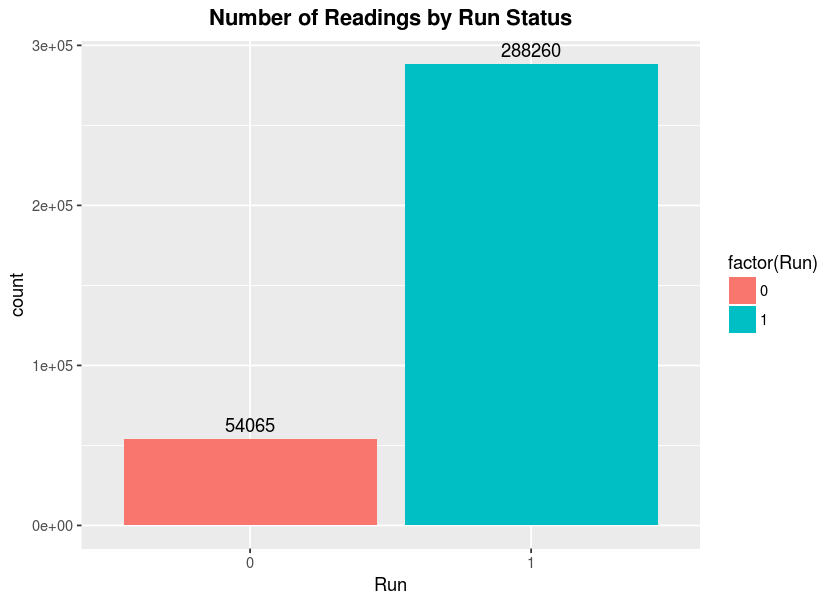

In [27]:
# bar chart of number of events by for running and non-running
ggplot(data = df, mapping = aes(x = Run)) +
  geom_bar(aes(fill = factor(Run))) +
  geom_text(stat = 'count', mapping = aes(label = ..count..), vjust = -.5) + 
  ggtitle("Number of Readings by Run Status") + 
  theme(plot.title = element_text(lineheight=.8, face="bold", hjust = 0.5))

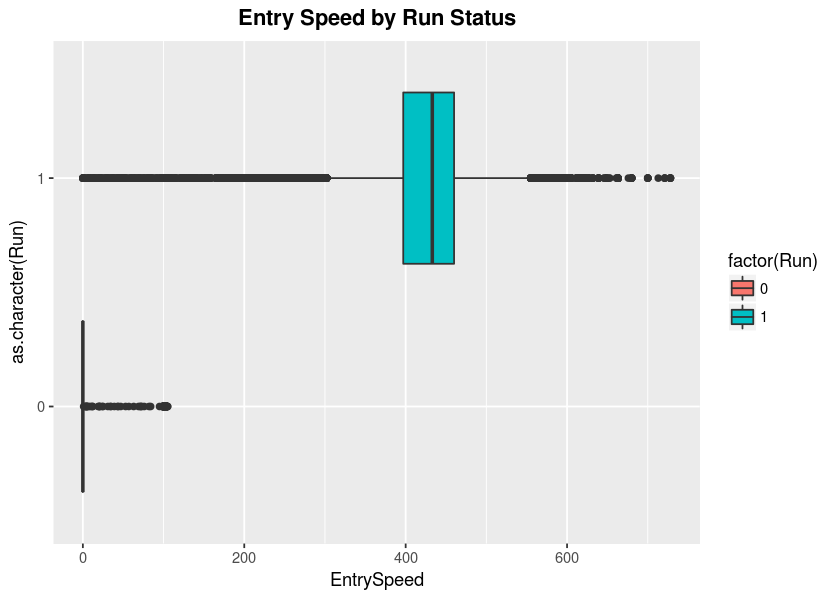

In [28]:
# boxplot of EntrySpeed by Run
ggplot(data = df, mapping = aes(x = as.character(Run), y = EntrySpeed)) +
  geom_boxplot(aes(fill = factor(Run))) +
  coord_flip() +
  ggtitle("Entry Speed by Run Status") + 
  theme(plot.title = element_text(lineheight=.8, face="bold", hjust = 0.5))

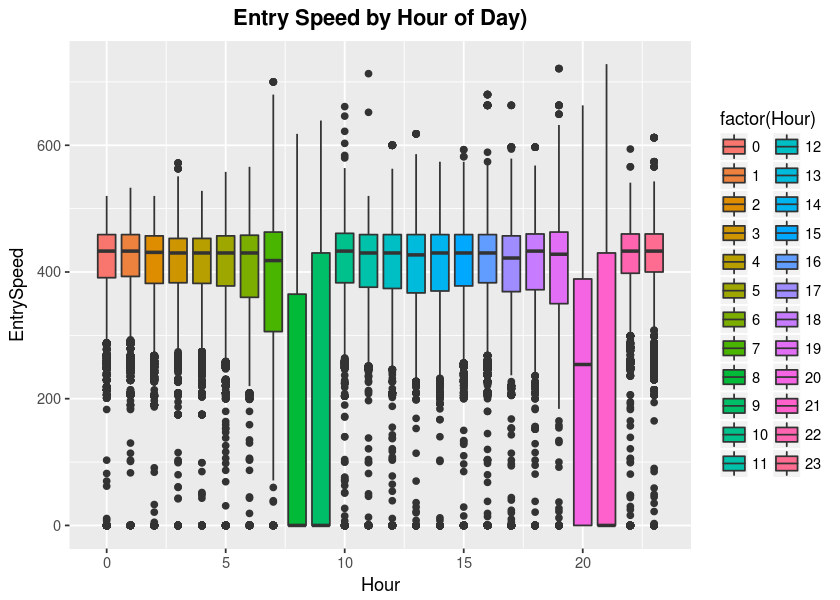

In [29]:
# boxplot of EntrySpeed by hour
ggplot(data = df, mapping = aes(x = Hour, y = EntrySpeed)) +
  geom_boxplot(aes(fill = factor(Hour))) +
  ggtitle("Entry Speed by Hour of Day)") + 
  theme(plot.title = element_text(lineheight=.8, face="bold", hjust = 0.5))

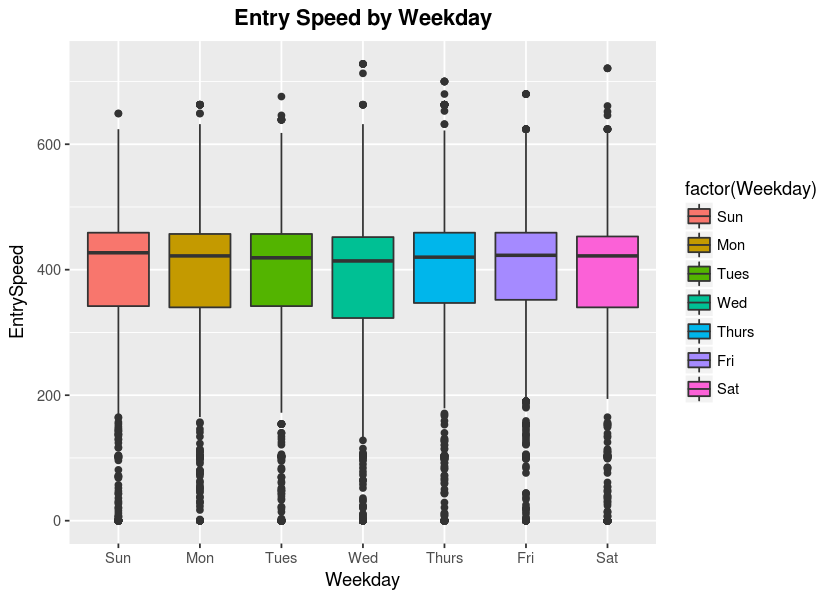

In [30]:
# boxplot of EntrySpeed by weekday
ggplot(data = df, mapping = aes(x = Weekday, y = EntrySpeed)) +
  geom_boxplot(aes(fill = factor(Weekday))) +
  ggtitle("Entry Speed by Weekday") + 
  theme(plot.title = element_text(lineheight=.8, face="bold", hjust = 0.5))

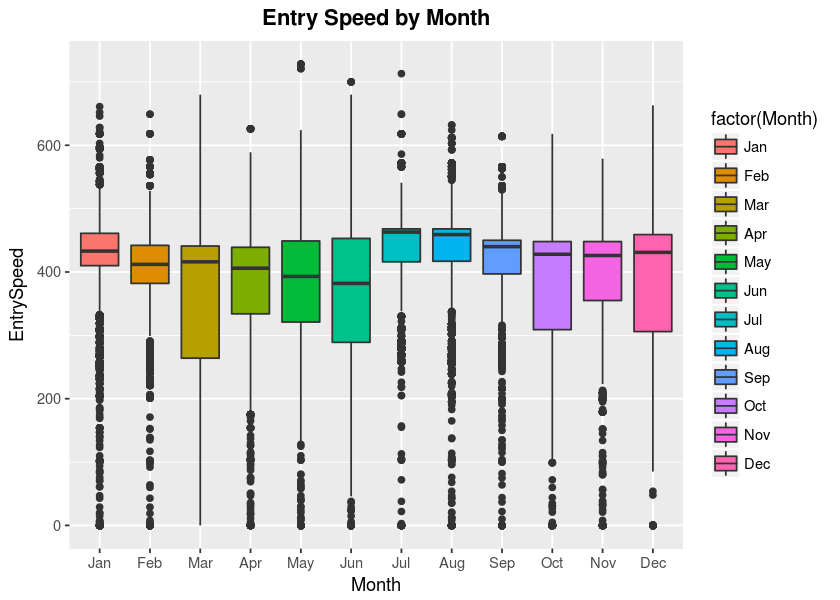

In [31]:
# boxplot of EntrySpeed by month
ggplot(data = df, mapping = aes(x = Month, y = EntrySpeed)) +
  geom_boxplot(aes(fill = factor(Month))) +
  ggtitle("Entry Speed by Month") + 
  theme(plot.title = element_text(lineheight=.8, face="bold", hjust = 0.5))

## Load Data With Failure Indicator

In [75]:
# create an open connection to the database
cn <- dbConnect(drv = RMySQL::MySQL(),
                host = "130.39.80.188",
                port = 3306,
                user = "champt9",
                password = "champt9",
                dbname = "hanes")

# query the database and store the results into a DataFrame
#db_list_tables(cn)
fail <- dbGetQuery(cn, "SELECT * FROM machine3_fail_1_hour_before")
#dbDisconnect(cn)

In [76]:
# convert Datetime_hour to datetime object
fail$Datetime_hour <- ymd_hms(fail$Datetime_hour)

In [77]:
# create a new variable for year, month, and day
fail$Year <- year(fail$Datetime)
fail$Month <- month(fail$Datetime, label=TRUE)
fail$Day <- day(fail$Datetime)
fail$Weekday <- wday(fail$Datetime, label=TRUE)
fail$Hour <- hour(fail$Datetime)

In [78]:
# drop the old failure variable and set the new failure variable as factor
fail$Class  <- as.factor(fail$NEW_FAIL)
fail$FAILURE <- NULL
fail$NEW_FAIL <- NULL

# create variable names for the Class variable
levels(fail$Class) <- make.names(c("notFail", "fail"))

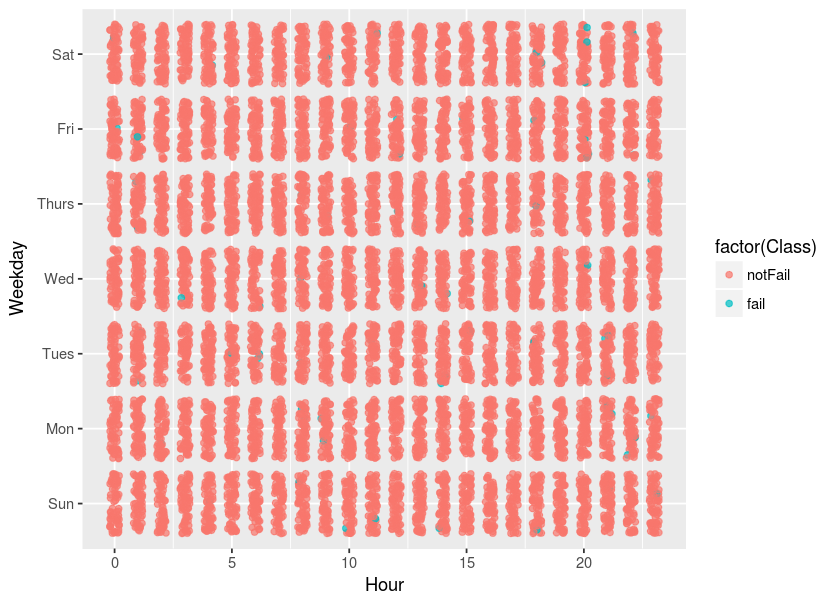

In [94]:
# boxplot of EntrySpeed by hour
ggplot(data = fail, mapping = aes(x = Hour, y = Weekday)) +
  geom_point(aes(color = factor(Class)), position=position_jitter(width=.2), alpha = 0.70)